In [ ]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/DataSets/dog&cat/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

### build network

In [85]:
overlap_size = 40

In [86]:
def channel_shuffle(x, groups=2):
  bat_size, channels, w, h = x.shape
  group_c = channels // groups
  x = x.view(bat_size, groups, group_c, w, h)
  x = t.transpose(x, 1, 2).contiguous()
  x = x.view(bat_size, -1, w, h)
  return x

# used in the block
def conv_1x1_bn(in_c, out_c, stride=1):
  return nn.Sequential(
    nn.Conv2d(in_c, out_c, 1, stride, 0, bias=False),
    nn.BatchNorm2d(out_c),
    nn.ReLU(True)
  )

def conv_bn(in_c, out_c, stride=2):
  return nn.Sequential(
    nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False),
    nn.BatchNorm2d(out_c),
    nn.ReLU(True)
  )


class ShuffleBlock(nn.Module):
  def __init__(self, in_c, out_c, downsample=False):
    super(ShuffleBlock, self).__init__()
    self.downsample = downsample
    half_c = out_c // 2
    input_overlap = (overlap_size*2)
    input_with_overlap = (half_c-overlap_size)

    if downsample:
      self.branch1 = nn.Sequential(
          # 3*3 dw conv, stride = 2
          nn.Conv2d(in_c, in_c, 3, 2, 1, groups=in_c, bias=False),
          nn.BatchNorm2d(in_c),
          # 1*1 pw conv
          nn.Conv2d(in_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True)
      )

      self.branch2 = nn.Sequential(
          # 1*1 pw conv
          nn.Conv2d(in_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True),
          # 3*3 dw conv, stride = 2
          nn.Conv2d(half_c, half_c, 3, 2, 1, groups=half_c, bias=False),
          nn.BatchNorm2d(half_c),
          # 1*1 pw conv
          nn.Conv2d(half_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True)
      )

      self.branch_overlaping = nn.Sequential(
          # 3*3 dw conv, stride = 2
          nn.Conv2d(in_c, in_c, 3, 2, 1, groups=in_c, bias=False),
          nn.BatchNorm2d(in_c),
          # 1*1 pw conv
          nn.Conv2d(in_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True)
      )

    else:
      # in_c = out_c
      assert in_c == out_c

      self.branch1 = nn.Sequential(
           # 1*1 pw conv
          nn.Conv2d(input_with_overlap, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True),
          # 3*3 dw conv, stride = 1
          nn.Conv2d(half_c, half_c, 3, 1, 1, groups=half_c, bias=False),
          nn.BatchNorm2d(half_c)
      )

      self.branch2 = nn.Sequential(
          # 1*1 pw conv
          nn.Conv2d(input_with_overlap, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True),
          # 3*3 dw conv, stride = 1
          nn.Conv2d(half_c, half_c, 3, 1, 1, groups=half_c, bias=False),
          nn.BatchNorm2d(half_c),
          # 1*1 pw conv
          nn.Conv2d(half_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True)
      )

      self.branch_overlaping = nn.Sequential(
          # 1*1 pw conv
          nn.Conv2d(input_overlap, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True),
          # 3*3 dw conv, stride = 1
          nn.Conv2d(half_c, half_c, 3, 1, 1, groups=half_c, bias=False),
          nn.BatchNorm2d(half_c),
          # 1*1 pw conv
          nn.Conv2d(half_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True)
      )


  def forward(self, x):
    out = None
    if self.downsample:
      # if it is downsampling, we don't need to do channel split
      branch1_with_overlap= t.add(self.branch1(x) , self.branch_overlaping(x))
      branch2_with_overlap= t.add(self.branch2(x) , self.branch_overlaping(x))
      out = t.cat((branch1_with_overlap, branch2_with_overlap), 1)
    else:
      # channel split
      channels = x.shape[1]
      c = channels // 2
      x1 = x[:, :(c-overlap_size), :, :]
      x_overlap = x[:, (c-overlap_size):(c+overlap_size), :, :]
      x2 = x[:, (c+overlap_size):, :, :]

      branch1 = self.branch1(x1)
      branch2 = self.branch2(x2)
      branch_overlap = self.branch_overlaping(x_overlap)

      branch1_with_overlap= t.add( branch1 , branch_overlap)
      branch2_with_overlap= t.add(branch2 , branch_overlap)

      out = t.cat((branch1_with_overlap, branch2_with_overlap), 1)
    return channel_shuffle(out,2)


class ShuffleNet2(nn.Module):
  def __init__(self, num_classes=2, input_size=224, net_type=1):
    super(ShuffleNet2, self).__init__()
    assert input_size % 32 == 0 # 因为一共会下采样32倍


    self.stage_repeat_num = [3,1,1]
    if net_type == 0.5:
      self.out_channels = [3, 24, 48, 96, 192, 1024]
    elif net_type == 1:
      self.out_channels = [3, 24, 116 , 116, 116 ,116]
    elif net_type == 1.5:
      self.out_channels = [3, 24, 176, 352, 704, 1024]
    elif net_type == 2:
      self.out_channels = [3, 24, 244, 488, 976, 2948]
    else:
      print("the type is error, you should choose 0.5, 1, 1.5 or 2")

    # let's start building layers
    self.conv1 = nn.Conv2d(3, self.out_channels[1], 3, 2, 1)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    in_c = self.out_channels[1]

    self.stages = []
    for stage_idx in range(len(self.stage_repeat_num)):
      out_c = self.out_channels[2+stage_idx]
      repeat_num = self.stage_repeat_num[stage_idx]
      print(f"in_c:{in_c} out_c:{out_c} repeat_num:{repeat_num}")
      for i in range(repeat_num):
        if i == 0:
          self.stages.append(ShuffleBlock(in_c, out_c, downsample=True))
        else:
          self.stages.append(ShuffleBlock(in_c, in_c, downsample=False))
        in_c = out_c
    self.stages = nn.Sequential(*self.stages)

    in_c = self.out_channels[-2]
    out_c = self.out_channels[-1]
    self.conv5 = conv_1x1_bn(in_c, out_c, 1)
    self.g_avg_pool = nn.AvgPool2d(kernel_size=(int)(input_size/32)) # 如果输入的是224，则此处为7

    # fc layer
    self.fc = nn.Linear(out_c, num_classes)


  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.stages(x)
    x = self.conv5(x)
    x = self.g_avg_pool(x)
    x = x.view(-1, self.out_channels[-1])
    x = self.fc(x)
    return x






In [87]:
model = ShuffleNet2()

in_c:24 out_c:116 repeat_num:3
in_c:116 out_c:116 repeat_num:1
in_c:116 out_c:116 repeat_num:1


In [88]:
t.cuda.is_available()

True

In [89]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device

device(type='cuda')

In [90]:
model = model.to(device)

### Process data

> You can modify this part to train on your own data.

The train data format

![image.png](attachment:image.png)

The test data format

![image.png](attachment:image.png)

In [91]:
from torchvision import datasets, transforms
import os
import time
from torch.utils import data
import numpy as np
from PIL import Image
import copy

[How to process data using Dataset, Dataloader](https://zhuanlan.zhihu.com/p/30934236)

In [92]:
class DogCat(data.Dataset):
  def __init__(self, root, trans=None, train=True, test=False):
    self.test = test
    self.train = train
    imgs = [os.path.join(root, img) for img in os.listdir(root)]
    '''
    the format of test and trian image name is different
    as for test: /test/102.jpg
    as for train: /train/cat.1.jpg
    '''
    if test: # root: './dogvscat/test/' imgs = ["xx/123.jpg", "xx/234.jpg", ...]
      sorted(imgs, key=lambda x: int(x.split(".")[-2].split("/")[-1]))
    else:
      sorted(imgs, key=lambda x: int(x.split(".")[-2]))

    # shuffle
    np.random.seed(100)
    imgs = np.random.permutation(imgs)

    # split dataset
    if self.test:
      self.imgs = imgs
    elif train:
      self.imgs = imgs[:int(0.7*len(imgs))]
    else:
      self.imgs = imgs[int(0.7*len(imgs)):]

    if trans==None:
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
      # test and dev dataset do not need to do data augemetation
      if self.test or not self.train:
        self.trans = transforms.Compose([
                                        transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        normalize
                                        ])
      else:
        self.trans = transforms.Compose([
                                        transforms.Resize(256),
                                        transforms.CenterCrop(224), # RandomSizedCrop(224)??
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        normalize
                                        ])


  def __getitem__(self, index):
    '''
    as for test: just return the id of picture.
    as for train and dev: return 1 if dog, return 0 if cat
    '''
    imgpath = self.imgs[index]
    if self.test:
      label = int(imgpath.split(".")[-2].split("/")[-1])
    else:
      kind = imgpath.split(".")[-3].split("/")[-1]
      label = 1 if kind == "dog" else 0
    img = Image.open(imgpath)
    img = self.trans(img)
    return img, label

  def __len__(self):
    return len(self.imgs)

In [93]:
train_dataset = DogCat("/content/train", train=True)
val_dataset = DogCat("/content/train", train=False, test=False)
train_loader = data.DataLoader(train_dataset,
                               batch_size = 32,
                               shuffle=True
                               )
val_loader = data.DataLoader(val_dataset,
                             batch_size = 32,
                             shuffle=True)


In [94]:
dataloader = {}
dataloader["train"] = train_loader
dataloader["val"] = val_loader

### training and validating

In [95]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
model = ShuffleNet2()
model = model.to(device)

in_c:24 out_c:116 repeat_num:3
in_c:116 out_c:116 repeat_num:1
in_c:116 out_c:116 repeat_num:1


In [96]:
loss_fn = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [97]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_loss_history = []
    train_loss_history = []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                with t.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs) # bsize * 2 , because it is a binary classification
                    loss = loss_fn(outputs, labels)

                preds = outputs.argmax(dim=1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += t.sum(preds.view(-1) == labels.view(-1)).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print("Phase {} loss: {}, acc: {}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_loss_history.append(epoch_acc)
            if(phase == "train"):
                train_loss_history.append(epoch_acc)
    model.load_state_dict(best_model_wts)
    return model, val_loss_history , train_loss_history

In [98]:
model, val_logs , train_logs = train_model(model, dataloader, loss_fn, optimizer)

Phase train loss: 0.5842210654803685, acc: 0.6992
Phase val loss: 0.6024106547196706, acc: 0.7001333333333334
Phase train loss: 0.4758065607888358, acc: 0.7764571428571428
Phase val loss: 0.5064914051691691, acc: 0.7832
Phase train loss: 0.40876457136017935, acc: 0.8153142857142858
Phase val loss: 0.3989848448117574, acc: 0.8262666666666667
Phase train loss: 0.3584041755369731, acc: 0.8432571428571428
Phase val loss: 0.3474107357819875, acc: 0.8506666666666667
Phase train loss: 0.3141325296470097, acc: 0.8675428571428572
Phase val loss: 0.2934560849269231, acc: 0.8764


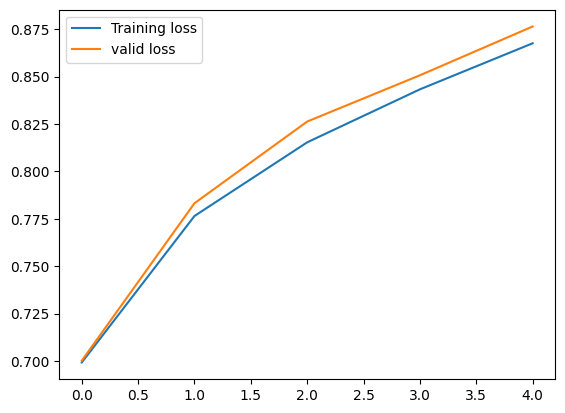

In [99]:
import matplotlib.pyplot as plt
plt.plot(train_logs, label="Training loss")
plt.plot(val_logs, label="valid loss")
plt.legend()

### save the best model

In [66]:
import time
import torch as t
filename = "./" + str(int(time.time()))+'.pkl'
t.save(model.state_dict(), filename)

## Test

In [67]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/DataSets/dog&cat/test.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")


In [68]:
test_dataset = DogCat("/content/test", train=False, test=True)
test_loader = data.DataLoader(test_dataset,
                             batch_size = 20,
                             shuffle=True)


In [69]:
state_dict = t.load(filename)
model.load_state_dict(state_dict)


<All keys matched successfully>

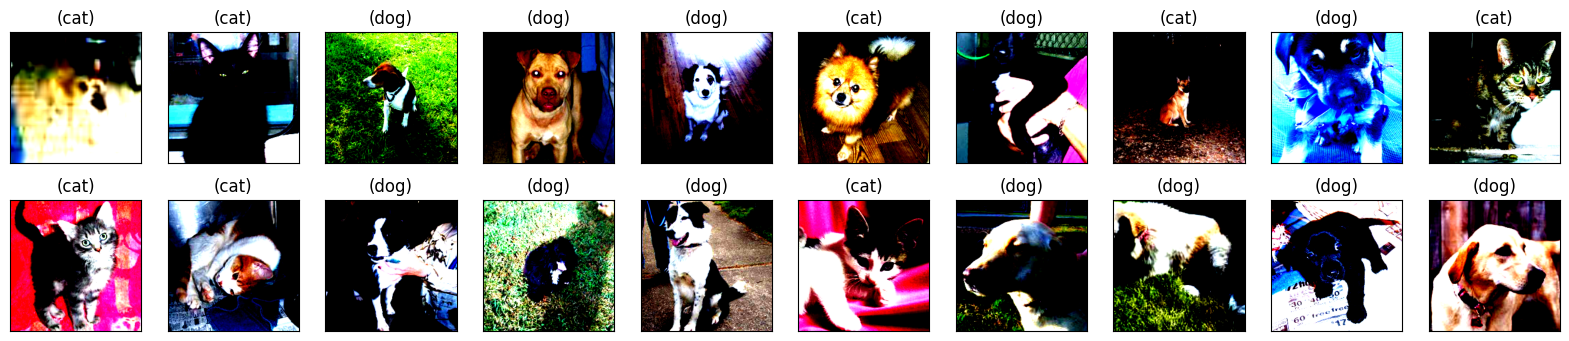

In [70]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 4))
idx = 0
test_data = next(iter(test_loader))

for images in test_data:
  inputs = images.to(device)

  outputs = model(inputs) # bsize * 2 , because it is a binary classification

  preds = outputs.argmax(dim=1)

  for image in images :
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(image.permute(1, 2, 0))
    ax.set_title("({})".format("dog" if preds[idx] == 1 else "cat"))
    idx+=1
  break



